In [1]:
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt

In [178]:
dataset = 'motor_temperature'

In [ ]:
dataset = "velocity_calc"

In [164]:
data = pd.read_csv('../data/'+dataset'/day_13.csv')
# remove index

print(data.head())  

                  time  motor_temperature
0  2022-12-13 00:00:00              46.65
1  2022-12-13 00:00:01              46.80
2  2022-12-13 00:00:02              46.70
3  2022-12-13 00:00:03              46.75
4  2022-12-13 00:00:04              46.75


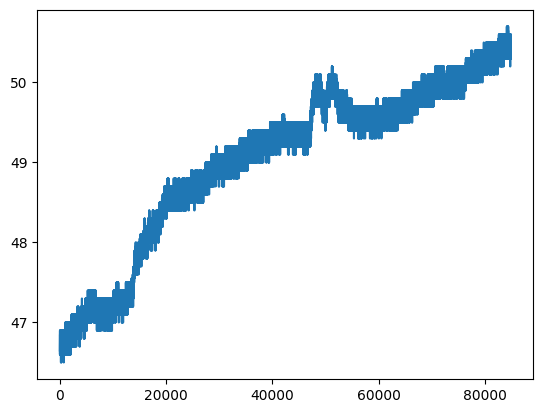

In [165]:
fig, ax = plt.subplots()
data.plot(legend=False, ax=ax)
plt.show()

In [166]:

# Normalize and save the mean and std we get,
# for normalizing test data.
training_mean = data.mean()
training_std = data.std()
df_training_value = (data - training_mean) / training_std
print(df_training_value.head() )
print("Number of training samples:", len(df_training_value))

   motor_temperature time
0          -2.310135  NaN
1          -2.165295  NaN
2          -2.261855  NaN
3          -2.213575  NaN
4          -2.213575  NaN
Number of training samples: 84847


C:\Users\verni\AppData\Local\Temp\ipykernel_22348\1523179978.py:3: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  training_mean = data.mean()
C:\Users\verni\AppData\Local\Temp\ipykernel_22348\1523179978.py:4: FutureWarning: The default value of numeric_only in DataFrame.std is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  training_std = data.std()


In [167]:
TIME_STEPS = 60

# Generated training sequences for use in the model.
def create_sequences(values, time_steps=TIME_STEPS):
    output = []
    for i in range(len(values) - time_steps + 1):
        output.append(values[i : (i + time_steps)])
    return np.stack(output)


x_train = create_sequences(df_training_value['motor_temperature'].values)
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
print("Training input shape: ", x_train.shape)

Training input shape:  (84788, 60, 1)


In [168]:
model = keras.Sequential(
    [
        layers.Input(shape=(x_train.shape[1], 1)),
        layers.Conv1D(
            filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Dropout(rate=0.2),
        layers.Conv1D(
            filters=16, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Conv1DTranspose(
            filters=16, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Dropout(rate=0.2),
        layers.Conv1DTranspose(
            filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Conv1DTranspose(filters=1, kernel_size=7, padding="same"),
    ]
)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")
model.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_6 (Conv1D)           (None, 30, 32)            256       
                                                                 
 dropout_6 (Dropout)         (None, 30, 32)            0         
                                                                 
 conv1d_7 (Conv1D)           (None, 15, 16)            3600      
                                                                 
 conv1d_transpose_9 (Conv1DT  (None, 30, 16)           1808      
 ranspose)                                                       
                                                                 
 dropout_7 (Dropout)         (None, 30, 16)            0         
                                                                 
 conv1d_transpose_10 (Conv1D  (None, 60, 32)           3616      
 Transpose)                                          

In [169]:
history = model.fit(
    x_train,
    x_train,
    epochs=50,
    batch_size=128,
    validation_split=0.1,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min")
    ],
)

Epoch 1/50
597/597 [==============================] - 7s 11ms/step - loss: 0.0445 - val_loss: 0.0352
Epoch 2/50
597/597 [==============================] - 6s 11ms/step - loss: 0.0087 - val_loss: 0.0432
Epoch 3/50
597/597 [==============================] - 7s 11ms/step - loss: 0.0058 - val_loss: 0.0429
Epoch 4/50
597/597 [==============================] - 6s 10ms/step - loss: 0.0049 - val_loss: 0.0418
Epoch 5/50
597/597 [==============================] - 6s 10ms/step - loss: 0.0043 - val_loss: 0.0296
Epoch 6/50
597/597 [==============================] - 6s 11ms/step - loss: 0.0039 - val_loss: 0.0502
Epoch 7/50
597/597 [==============================] - 6s 10ms/step - loss: 0.0036 - val_loss: 0.0307
Epoch 8/50
597/597 [==============================] - 6s 10ms/step - loss: 0.0033 - val_loss: 0.0363
Epoch 9/50
597/597 [==============================] - 6s 10ms/step - loss: 0.0031 - val_loss: 0.0448
Epoch 10/50
597/597 [==============================] - 6s 10ms/step - loss: 0.0029 - val_lo

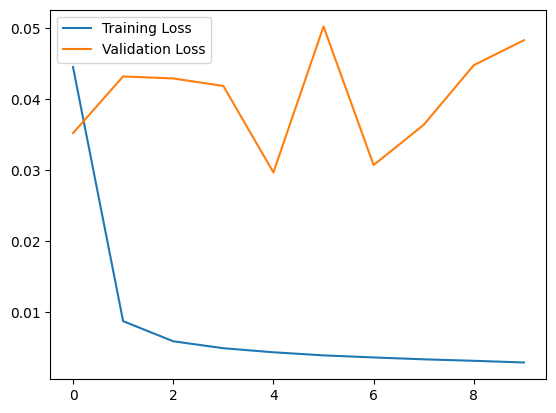

In [170]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()

2650/2650 [==============================] - 6s 2ms/step


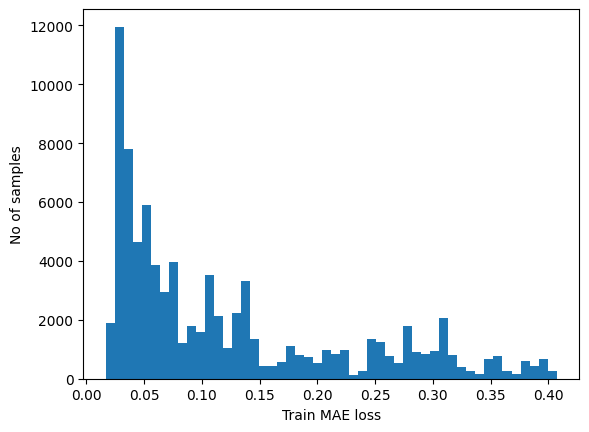

Reconstruction error threshold:  0.40701809037109643


In [171]:
# Get train MAE loss.
x_train_pred = model.predict(x_train)
train_mae_loss = np.mean(np.abs(x_train_pred - x_train), axis=1)

plt.hist(train_mae_loss, bins=50)
plt.xlabel("Train MAE loss")
plt.ylabel("No of samples")
plt.show()

# Get reconstruction loss threshold.
threshold = np.max(train_mae_loss)
print("Reconstruction error threshold: ", threshold)

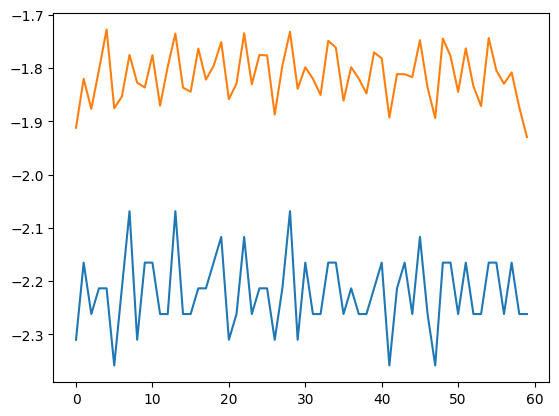

In [172]:
# Checking how the first sequence is learnt
plt.plot(x_train[0])
plt.plot(x_train_pred[0])
plt.show()

In [173]:
print(x_train_pred[0])
print(x_train[0])

[[-1.912119 ]
 [-1.8201588]
 [-1.8767154]
 [-1.8038135]
 [-1.7275645]
 [-1.87557  ]
 [-1.85345  ]
 [-1.775434 ]
 [-1.827492 ]
 [-1.8365048]
 [-1.7756629]
 [-1.8705993]
 [-1.7974262]
 [-1.7352452]
 [-1.8368323]
 [-1.8443536]
 [-1.7634166]
 [-1.8216155]
 [-1.7961116]
 [-1.7512946]
 [-1.8583481]
 [-1.8292813]
 [-1.7346938]
 [-1.8304443]
 [-1.7753711]
 [-1.7762822]
 [-1.8873475]
 [-1.7955177]
 [-1.7318441]
 [-1.8388686]
 [-1.7985489]
 [-1.8201147]
 [-1.8503927]
 [-1.749012 ]
 [-1.7615595]
 [-1.861218 ]
 [-1.7984089]
 [-1.8198048]
 [-1.8476869]
 [-1.7705922]
 [-1.7817389]
 [-1.8929542]
 [-1.8113881]
 [-1.8115352]
 [-1.8169882]
 [-1.7476536]
 [-1.8366379]
 [-1.8938782]
 [-1.744493 ]
 [-1.7773814]
 [-1.8447897]
 [-1.7630055]
 [-1.8342388]
 [-1.871481 ]
 [-1.7436509]
 [-1.804497 ]
 [-1.8295195]
 [-1.8081505]
 [-1.8737463]
 [-1.9295781]]
[[-2.31013451]
 [-2.16529546]
 [-2.26185483]
 [-2.21357515]
 [-2.21357515]
 [-2.3584142 ]
 [-2.21357515]
 [-2.0687361 ]
 [-2.31013451]
 [-2.16529546]
 [-2.1652

In [176]:
test = pd.read_csv('../data/motor_temperature/day_14.csv')
test_value = (test - training_mean) / training_std
print(test_value.head() )
print("Number of training samples:", len(test_value))

# Prepare test data.
x_test = create_sequences(test_value['motor_temperature'].values)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)
print("Test input shape: ", x_test.shape)


   motor_temperature time
0           1.455681  NaN
1           1.407401  NaN
2           1.310842  NaN
3           1.407401  NaN
4           1.359121  NaN
Number of training samples: 84692
Test input shape:  (84633, 60, 1)


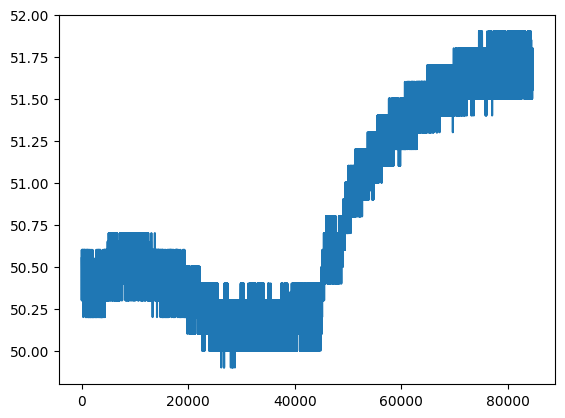

2645/2645 [==============================] - 7s 2ms/step


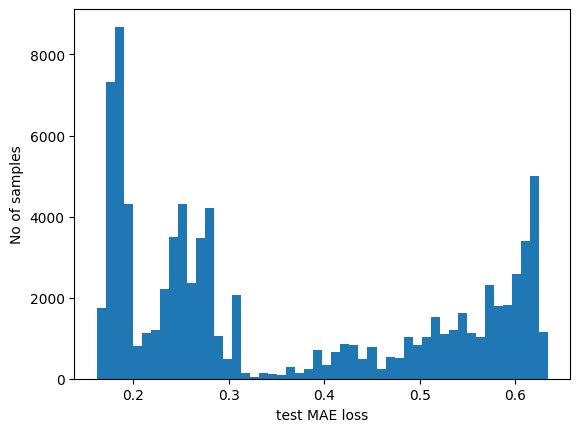

Number of anomaly samples:  33486
Indices of anomaly samples:  (array([51138, 51144, 51147, ..., 84630, 84631, 84632], dtype=int64),)


In [177]:
fig, ax = plt.subplots()
test.plot(legend=False, ax=ax)
plt.show()

# Get test MAE loss.
x_test_pred = model.predict(x_test)
test_mae_loss = np.mean(np.abs(x_test_pred - x_test), axis=1)
test_mae_loss = test_mae_loss.reshape((-1))

plt.hist(test_mae_loss, bins=50)
plt.xlabel("test MAE loss")
plt.ylabel("No of samples")
plt.show()

# Detect all the samples which are anomalies.
anomalies = test_mae_loss > threshold
print("Number of anomaly samples: ", np.sum(anomalies))
print("Indices of anomaly samples: ", np.where(anomalies))

   motor_temperature time
0          -0.234108  NaN
1          -0.137549  NaN
2          -0.234108  NaN
3          -0.137549  NaN
4          -0.137549  NaN
Number of training samples: 17964
Test input shape:  (17905, 60, 1)


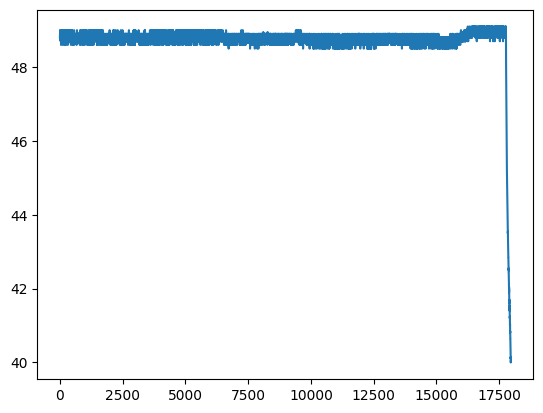

560/560 [==============================] - 1s 3ms/step


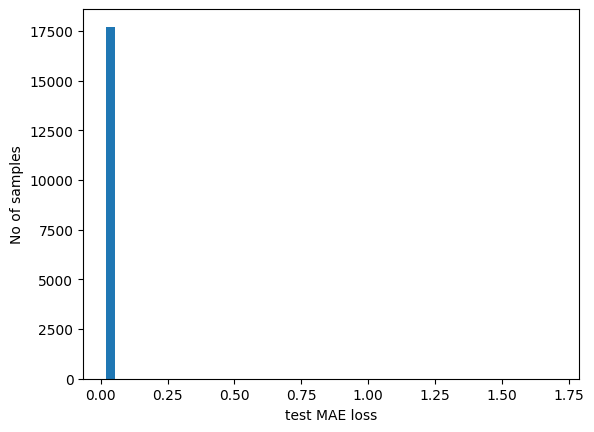

Number of anomaly samples:  153
Indices of anomaly samples:  (array([17752, 17753, 17754, 17755, 17756, 17757, 17758, 17759, 17760,
       17761, 17762, 17763, 17764, 17765, 17766, 17767, 17768, 17769,
       17770, 17771, 17772, 17773, 17774, 17775, 17776, 17777, 17778,
       17779, 17780, 17781, 17782, 17783, 17784, 17785, 17786, 17787,
       17788, 17789, 17790, 17791, 17792, 17793, 17794, 17795, 17796,
       17797, 17798, 17799, 17800, 17801, 17802, 17803, 17804, 17805,
       17806, 17807, 17808, 17809, 17810, 17811, 17812, 17813, 17814,
       17815, 17816, 17817, 17818, 17819, 17820, 17821, 17822, 17823,
       17824, 17825, 17826, 17827, 17828, 17829, 17830, 17831, 17832,
       17833, 17834, 17835, 17836, 17837, 17838, 17839, 17840, 17841,
       17842, 17843, 17844, 17845, 17846, 17847, 17848, 17849, 17850,
       17851, 17852, 17853, 17854, 17855, 17856, 17857, 17858, 17859,
       17860, 17861, 17862, 17863, 17864, 17865, 17866, 17867, 17868,
       17869, 17870, 17871, 

In [180]:
test2 = pd.read_csv('../data/'+dataset+'/day_18.csv')
test_value2 = (test2 - training_mean) / training_std
print(test_value2.head() )
print("Number of training samples:", len(test_value2))

# Prepare test data.
x_test2 = create_sequences(test_value2[dataset].values)
x_test2 = x_test2.reshape(x_test2.shape[0], x_test2.shape[1], 1)
print("Test input shape: ", x_test2.shape)


fig, ax = plt.subplots()
test2.plot(legend=False, ax=ax)
plt.show()

# Get test MAE loss.
x_test_pred2 = model.predict(x_test2)
test_mae_loss2 = np.mean(np.abs(x_test_pred2 - x_test2), axis=1)
test_mae_loss2 = test_mae_loss2.reshape((-1))

plt.hist(test_mae_loss2, bins=50)
plt.xlabel("test MAE loss")
plt.ylabel("No of samples")
plt.show()

# Detect all the samples which are anomalies.
anomalies2 = test_mae_loss2 > threshold
print("Number of anomaly samples: ", np.sum(anomalies2))
print("Indices of anomaly samples: ", np.where(anomalies2))



ValueError: x and y can be no greater than 2D, but have shapes (17905,) and (17905, 60, 1)

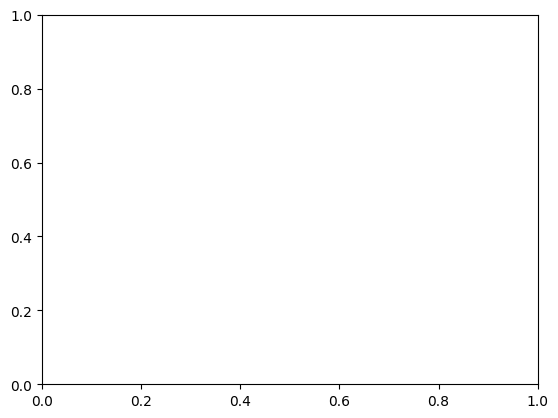

In [190]:
# data i is an anomaly if samples [(i - timesteps + 1) to (i)] are anomalies
anomalous_data_indices = []
for data_idx in range(TIME_STEPS - 1, len(test) - TIME_STEPS + 1):
    if np.all(anomalies[data_idx - TIME_STEPS + 1 : data_idx]):
        anomalous_data_indices.append(data_idx)


df_subset = test.iloc[anomalous_data_indices]
fig, ax = plt.subplots()
# test.plot(legend=False, ax=ax)
plt.plot(x_test_pred2 )
df_subset.plot(legend=False, color="r")
plt.show()



[]
[False False False ...  True  True  True]


AttributeError: 'numpy.ndarray' object has no attribute 'plt'

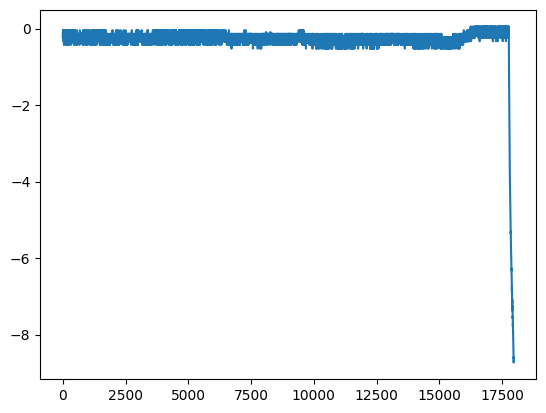

In [182]:
# data i is an anomaly if samples [(i - timesteps + 1) to (i)] are anomalies
anomalous_data_indices = []
for data_idx in range(TIME_STEPS - 1, len(test_value2) - TIME_STEPS + 1):
    if np.all(anomalies[data_idx - TIME_STEPS + 1 : data_idx]):
        anomalous_data_indices.append(data_idx)

print(anomalous_data_indices)
print(anomalies2)

#append none values to the start of anomalies2
for i in range(0,TIME_STEPS-1):
    anomalies2 = np.insert(anomalies2,0,False)
    



df_subset = test_value2.iloc[anomalous_data_indices]
fig, ax = plt.subplots()
test_value2.plot(legend=False, ax=ax)
# add the anomaly data using indices
anomalies2.plt(legend=False, ax=ax, color="r")
plt.show()




In [184]:
df_subset = test2.iloc[anomalies2]

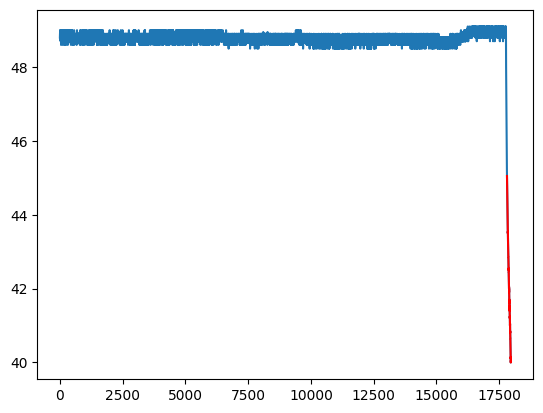

In [185]:
fig, ax = plt.subplots()
test2.plot(legend=False, ax=ax)
df_subset.plot(legend=False, ax=ax, color="r")
plt.show()

  time    torque
0  NaN -1.463111
1  NaN -0.240978
2  NaN -1.279791
3  NaN -0.577065
4  NaN -0.729831
Test input shape:  (86309, 60, 1)


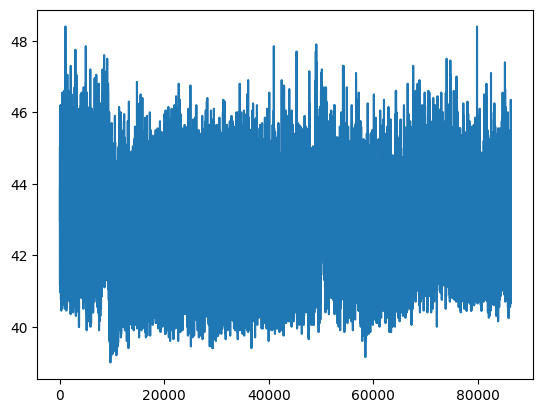

2698/2698 [==============================] - 7s 2ms/step


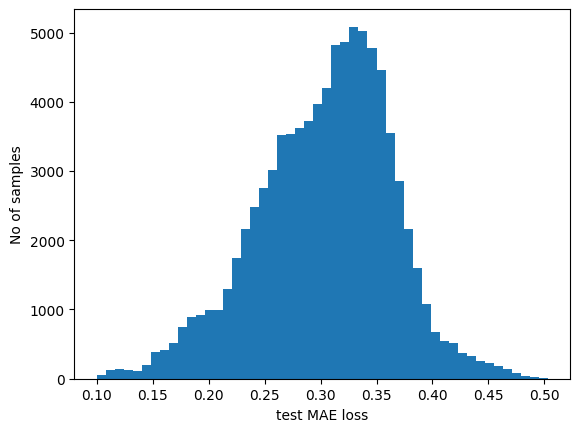

Number of anomaly samples:  428
Indices of anomaly samples:  (array([ 9513,  9514,  9515,  9516,  9517,  9518,  9519,  9520,  9521,
        9522,  9523,  9524,  9525,  9526,  9527,  9528,  9529,  9530,
        9531,  9532,  9533,  9534,  9535,  9536,  9537,  9538,  9539,
        9540,  9541,  9542,  9543,  9544,  9545,  9546,  9547,  9548,
        9549,  9550,  9551,  9552,  9553,  9554,  9555,  9556,  9557,
        9558,  9559,  9561,  9941,  9943,  9944,  9945,  9946,  9949,
        9951,  9959,  9965,  9967,  9969,  9970,  9971,  9972, 10037,
       10038, 10039, 10041, 10043, 10045, 10046, 10047, 10048, 10049,
       10051, 10052, 10053, 10054, 10055, 10056, 10057, 10058, 10059,
       10060, 10061, 10062, 10127, 10129, 10131, 10132, 10133, 10134,
       10201, 10203, 10205, 10217, 10218, 10219, 10221, 10224, 10225,
       10291, 10293, 10294, 10295, 10296, 10297, 10298, 10299, 10300,
       10301, 10302, 10303, 10304, 10305, 10306, 10307, 10308, 10309,
       10310, 10311, 10372, 

IndexError: Boolean index has wrong length: 86309 instead of 86368

In [163]:
test3 = pd.read_csv('../data/torque/day_17.csv')
test_value3 = (test3 - training_mean) / training_std
print(test_value3.head() )

# Prepare test data.
x_test3 = create_sequences(test_value3['torque'].values)
x_test3 = x_test3.reshape(x_test3.shape[0], x_test3.shape[1], 1)
print("Test input shape: ", x_test3.shape)


fig, ax = plt.subplots()
test3.plot(legend=False, ax=ax)
plt.show()

# Get test MAE loss.
x_test_pred3 = model.predict(x_test3)
test_mae_loss3 = np.mean(np.abs(x_test_pred3 - x_test3), axis=1)
test_mae_loss3 = test_mae_loss3.reshape((-1))

plt.hist(test_mae_loss3, bins=50)
plt.xlabel("test MAE loss")
plt.ylabel("No of samples")
plt.show()

# Detect all the samples which are anomalies.
anomalies3 = test_mae_loss3 > threshold
print("Number of anomaly samples: ", np.sum(anomalies3))
print("Indices of anomaly samples: ", np.where(anomalies3))

# data i is an anomaly if samples [(i - timesteps + 1) to (i)] are anomalies
anomalous_data_indices = []
for data_idx in range(TIME_STEPS - 1, len(test3) - TIME_STEPS + 1):
    if np.all(anomalies3[data_idx - TIME_STEPS + 1 : data_idx]):
        anomalous_data_indices.append(data_idx)


df_subset = test3.iloc[anomalous_data_indices]
fig, ax = plt.subplots()
test3.plot(legend=False, ax=ax)
df_subset.plot(legend=False, ax=ax, color="r")
plt.show()



  time     torque
0  NaN -27.677868
1  NaN -27.708422
2  NaN -27.647315
3  NaN -27.769528
4  NaN -27.952848
Test input shape:  (61084, 60, 1)


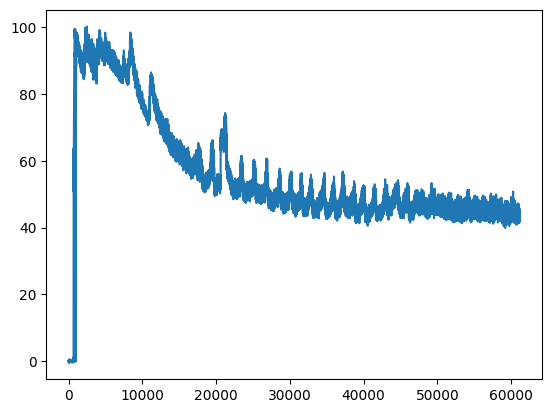

1909/1909 [==============================] - 5s 3ms/step


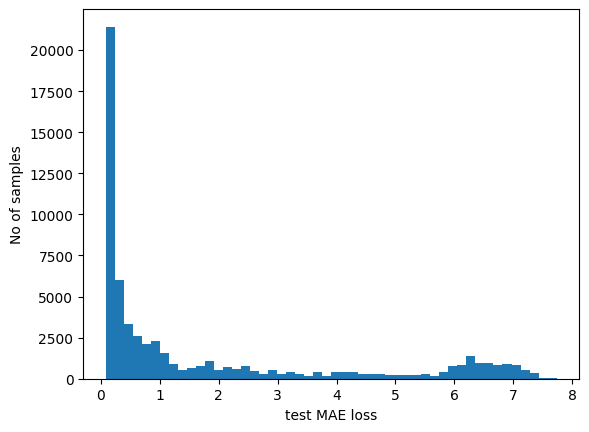

Number of anomaly samples:  31796
Indices of anomaly samples:  (array([    0,     1,     2, ..., 49205, 49206, 49207], dtype=int64),)


In [144]:
testday1 = pd.read_csv('../data/torque/day_12.csv')
testday1_value = (testday1 - training_mean) / training_std
print(testday1_value.head() )

# Prepare test data.
x_testday1 = create_sequences(testday1_value['torque'].values)
x_testday1 = x_testday1.reshape(x_testday1.shape[0], x_testday1.shape[1], 1)
print("Test input shape: ", x_testday1.shape)


fig, ax = plt.subplots()
testday1.plot(legend=False, ax=ax)
plt.show()

# Get test MAE loss.
x_testday1_pred = model.predict(x_testday1)
testday1_mae_loss = np.mean(np.abs(x_testday1_pred - x_testday1), axis=1)
testday1_mae_loss = testday1_mae_loss.reshape((-1))

plt.hist(testday1_mae_loss, bins=50)
plt.xlabel("test MAE loss")
plt.ylabel("No of samples")
plt.show()

# Detect all the samples which are anomalies.
anomaliesday1 = testday1_mae_loss > threshold
print("Number of anomaly samples: ", np.sum(anomaliesday1))
print("Indices of anomaly samples: ", np.where(anomaliesday1))


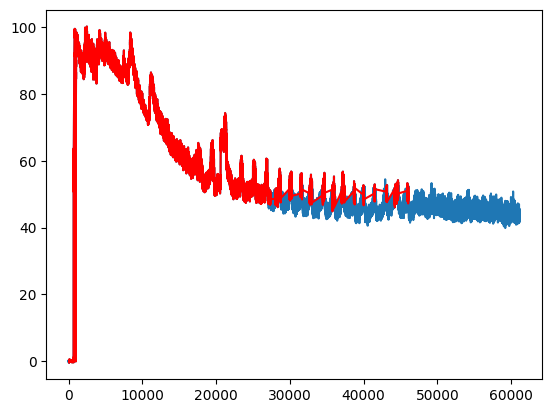

In [149]:

# data i is an anomaly if samples [(i - timesteps + 1) to (i)] are anomalies
anomalous_data_indices = []
for data_idx in range(TIME_STEPS - 1, len(testday1) - TIME_STEPS + 1):
    if np.all(anomaliesday1[data_idx - TIME_STEPS + 1 : data_idx]):
        anomalous_data_indices.append(data_idx)


df_subset = testday1.iloc[anomalous_data_indices]
fig, ax = plt.subplots()
testday1.plot(legend=False, ax=ax)
df_subset.plot(legend=False, ax=ax, color="r")
plt.show()


ValueError: x and y can be no greater than 2D, but have shapes (61084,) and (61084, 60, 1)

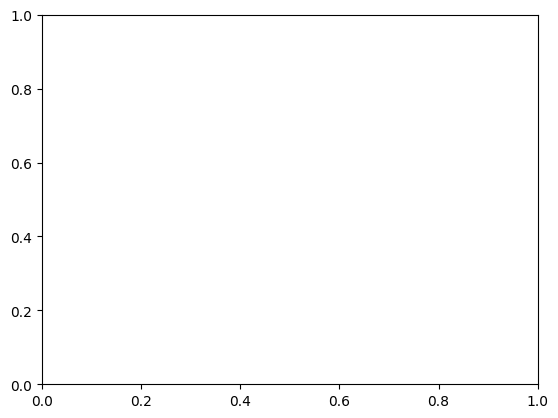

In [162]:
# Checking how the first sequence is learnt
plt.plot(x_testday1)
plt.plot(x_testday1_pred)
plt.legend(["Test", "Pred"])
plt.show()



In [4]:
import tensorflow as tf
import datetime

model = tf.keras.models.load_model('./dir/models/velocity_calc/1')
print('model loaded')


model loaded


In [7]:
import pandas as pd

data = pd.read_csv('../data/velocity_calc/day_13.csv')
from utilities import get_data
dataset = 'velocity_calc'
time_step = 20
offset = 30

X_train, y_train, X_test, y_test, scaler = get_data(dataset, time_step, offset, scaler=None, test=False, data=data, scale=True)

evaluation = model.evaluate(X_test, y_test)
print(evaluation)
# add to csv
current_date = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
add_metrics = pd.DataFrame([{'dataset': dataset,'loss':str(evaluation[0]), 'accuracy':str(evaluation[1]), 'time_added': current_date}])
add_metrics.to_csv('./dir/models/evaluation_metrics.csv', mode='a', index=False, header=False)

23.33291613036106
start 0
23.33291613036106
end 86399
scaling
539/539 [==============================] - 5s 8ms/step - loss: 0.0619
0.061913248151540756


TypeError: 'float' object is not subscriptable

In [8]:

def predict(model, X_test, y_test, scaler):
    # Make predictions
    test_predict = model.predict(X_test)
    print(test_predict[0])
    # Inverse transform to get the original scale
    print('scaling inverse')
    print(test_predict.shape)

    test_predict = scaler.inverse_transform(test_predict.reshape(-1, 1))
    y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

    return test_predict, y_test

In [3]:
import tensorflow as tf

model = tf.keras.models.load_model('./dir/models_new/velocity_calc')



In [5]:
import pandas as pd

data = pd.read_csv('../data/velocity_calc/day_13.csv')

from utilities import get_data
dataset = 'velocity_calc'
time_step = 60
offset = 60

X_train, y_train, X_test, y_test, scaler = get_data(dataset, time_step, offset, scaler=None, test=False, data=data, scale=True)



here                   time  velocity_calc
0  2022-12-13 00:00:00      23.335056
1  2022-12-13 00:00:01      23.333600
2  2022-12-13 00:00:02      23.330192
3  2022-12-13 00:00:03      23.335917
4  2022-12-13 00:00:04      23.329600
23.33291613036106
start 0
23.33291613036106
end 86399
scaling
537/537 [==============================] - 7s 12ms/step
scaling inverse


ValueError: Found array with dim 3. None expected <= 2.

In [9]:

test_predict, y_test = predict(model, X_test, y_test, scaler)


537/537 [==============================] - 7s 12ms/step
[[0.47416887]
 [0.47243455]
 [0.47122893]
 [0.4707373 ]
 [0.4707451 ]
 [0.47073495]
 [0.4708233 ]
 [0.47091213]
 [0.47068244]
 [0.4706607 ]
 [0.47064576]
 [0.47047716]
 [0.4705965 ]
 [0.47041672]
 [0.47037235]
 [0.47046584]
 [0.47027725]
 [0.4704893 ]
 [0.47041005]
 [0.47032332]
 [0.47051105]
 [0.4703512 ]
 [0.470453  ]
 [0.47043175]
 [0.47034836]
 [0.47057077]
 [0.47038084]
 [0.47039074]
 [0.47038916]
 [0.4703179 ]
 [0.47057605]
 [0.47036594]
 [0.47037858]
 [0.4703975 ]
 [0.47026795]
 [0.47039437]
 [0.47030312]
 [0.4703777 ]
 [0.47048095]
 [0.47038555]
 [0.47048965]
 [0.47039405]
 [0.47043908]
 [0.47052002]
 [0.47039944]
 [0.4704581 ]
 [0.47027266]
 [0.47030303]
 [0.47041804]
 [0.47031507]
 [0.47048813]
 [0.47046688]
 [0.47041082]
 [0.4705576 ]
 [0.4703633 ]
 [0.4704814 ]
 [0.47044054]
 [0.47033516]
 [0.470437  ]
 [0.4703528 ]]
scaling inverse
(17159, 60, 1)
